In [42]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pickle as pkl

# 1. Path to the files

In [14]:
name_data = '/mnt/archive/data/sub1_mc' # Directory of your new dataset

feature_path = os.path.join(name_data, 'scheme/unknown_snr/gradients/data_cat/features.nii')
ind_path = os.path.join(name_data, 'scheme/unknown_snr/gradients/data_cat/ind.pkl')
feature_path_pkl = os.path.join(name_data, 'scheme/unknown_snr/gradients/data/')
m_path = os.path.join(name_data, 'scheme/unknown_snr/gradients/data_cat/mask.nii')
be_path = os.path.join(name_data, 'scheme/scheme/bvecs.bvecs')
ba_path = os.path.join(name_data, 'scheme/scheme/bvals.bvals')

# 2. Directory creation

In [5]:
os.mkdir(name_data)
os.mkdir(name_data+'/scheme')
os.mkdir(name_data+'/scheme/scheme')
os.mkdir(name_data+'/scheme/unknown_snr')
os.mkdir(name_data+'/scheme/unknown_snr/gradients')
os.mkdir(name_data+'/scheme/unknown_snr/gradients/data_cat')
os.mkdir(name_data+'/scheme/unknown_snr/gradients/data')

# 3. Copy bvals, bvecs, nifti and brain mask into the corresponding directories (user has to do it manualy)

In [19]:
print('copy bvecs under {0}'.format(be_path))
print('copy bvals under {0}'.format(ba_path))
print('copy nifti under {0}'.format(feature_path))
print('copy mask under {0}'.format(m_path))

copy bvecs under /mnt/archive/data/sub1_mc/scheme/scheme/bvecs.bvecs
copy bvals under /mnt/archive/data/sub1_mc/scheme/scheme/bvals.bvals
copy nifti under /mnt/archive/data/sub1_mc/scheme/unknown_snr/gradients/data_cat/features.nii
copy mask under /mnt/archive/data/sub1_mc/scheme/unknown_snr/gradients/data_cat/mask.nii


# 4. Visualisation of the data

In [47]:
img = nib.load(feature_path)
data = img.get_fdata()


mask_img = nib.load(m_path)
mask = mask_img.get_fdata()

bvec =  np.loadtxt(be_path)
bval =  np.loadtxt(ba_path)


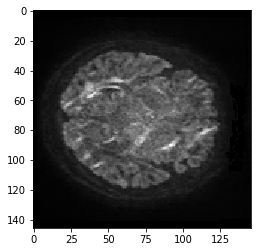

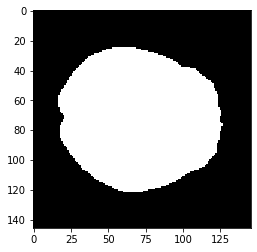

In [48]:
plt.imshow(data[:, :, 43, 1], cmap='gray')
plt.show()
plt.imshow(mask[:, :, 43], cmap='gray')
plt.show()

# 5. Refine the mask - delete previous mask!

In [46]:
ind_mask = mask != 0
ind_neg_signal = np.sum(data[:, :, :]<=0, axis=-1)==0
ind = ind_mask * ind_neg_signal
mask_corrected = nib.Nifti1Image(ind.astype(int), mask_img.affine, mask_img.header)
nib.save(mask_corrected, m_path)
data_nn = data[ind]

# 6. Information

In [49]:
print('Data shape: ', data.shape)
print('Mask shape: ', mask.shape)
print('N positif voxels: ', data_nn.shape[0])
print('Bvecs shape: ', bvec.shape)
print('Bvals shape: ', bval.shape)
print('Shell: ', np.unique(bval, return_counts=True)[0])
print('N gradient: ', np.unique(bval, return_counts=True)[1])

Data shape:  (146, 146, 92, 96)
Mask shape:  (146, 146, 92)
N positif voxels:  475454
Bvecs shape:  (96, 3)
Bvals shape:  (96,)
Shell:  [   0. 1000. 2000. 3000.]
N gradient:  [ 6 30 30 30]


# 7. Save pickle

In [ ]:
n_save = 1000
n_data, n_points = data_nn.shape
simulated_input_gradient = np.ones((min(n_data, n_save), n_points))
for i in range(n_data):
    # Save the simulated signal
    simulated_input_gradient[i - ((i + 1) // n_save) * n_save] = data_nn[i]

    # Save the files every n_save voxel and initialize the output objects
    if (i + 1) % n_save == 0:
        outfile = open(feature_path_pkl + 'features' + str((i + 1) // n_save) + '.pkl', 'wb')
        pkl.dump(simulated_input_gradient, outfile)
        outfile.close()
        print((i + 1) // n_save, ': ', simulated_input_gradient.shape)
        simulated_input_gradient = np.ones((min(n_data - ((i + 1) // n_save) * n_save, n_save), n_points))
        

# Last save
if simulated_input_gradient.shape[0] != 0:
    outfile = open(feature_path_pkl + 'features' + str(n_data // n_save + 1) + '.pkl', 'wb')
    pkl.dump(simulated_input_gradient, outfile)
    outfile.close()
    print(n_data // n_save + 1, ': ', simulated_input_gradient.shape)

# 8. Save indice of the saved voxels

In [ ]:
pkl.dump(ind, open(ind_path, 'wb'))

# 9. Save bvecs and bvals

In [ ]:
if bvec.shape[0] == 3:
    bvec = bvec.T
np.savetxt(be_path, bvec)
np.savetxt(ba_path, bval)